**Algorithms for Massive Datasets**  - Vojimir Ranitovic matricola:963780


---


**Market-basket analysis (Ukraine Conflict)**





In [1]:
%%capture 
!pip install pyspark  
!pip install findspark

In [2]:
%%capture  
import   pyspark  
import   os  
import   pandas   as   pd  
import   numpy   as   np  
import   csv  
import   re  
import   string  
import   nltk  
nltk.download (  'all'  ); #all  
from   nltk.corpus   import   stopwords  
from   nltk.tokenize   import   word_tokenize  
#from nltk.stem import PorterStemmer  
from   nltk.stem   import   WordNetLemmatizer  
import   time 
import matplotlib.pyplot  as  plt

Importing dataset from Kaggle

In [3]:
os.environ["KAGGLE_USERNAME"] = 'vojimirranitovic'
os.environ["KAGGLE_KEY"] = '8823ff207b2176411ae291b462ef9765'

ref = 'bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows'
!mkdir datasets
!kaggle datasets download $ref --unzip -p ./datasets

100% 8.62G/8.64G [01:02<00:00, 217MB/s]
100% 8.64G/8.64G [01:02<00:00, 148MB/s]


In [4]:
# From whole dataset I chose only dataset for 21th April. There are 361151 tweets.
OneFile = r"./datasets/0421_UkraineCombinedTweetsDeduped.csv.gzip"
df = pd.read_csv(OneFile, compression='gzip', encoding='utf-8', quoting=csv.QUOTE_ALL)

In [5]:
df.count() #there is 361151 tweets

Unnamed: 0        361151
userid            361151
username          361151
acctdesc          281595
location          189232
following         361151
followers         361151
totaltweets       361151
usercreatedts     361151
tweetid           361151
tweetcreatedts    361151
retweetcount      361151
text              361151
hashtags          361151
language          361151
coordinates          109
favorite_count    361151
extractedts       361151
dtype: int64

In [6]:
only_english=df[df['language'].str.contains('en')] # filtering only tweets on english language. There are 261202 on English, so there are around 70% of english tweets among other languages.

In [7]:
ENdf=only_english[{"text"}]

In [8]:
ENdf=ENdf.sample(frac=0.01, replace=False, random_state=1) #randomly taking 1% of dataset =2612 rows (tweets)

In [9]:
ENdf=ENdf.text.tolist() 

Initializing Spark environment

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate() #local[*] to run worker node threads on all available cores - in my case it is 2
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer") # I set KryoSerializer (default is Java)

In [11]:
spark.sparkContext.getConf().get("spark.serializer")

'org.apache.spark.serializer.KryoSerializer'

Preparing functions for *pre-processing* the data and *parallelizing data*


In [12]:
stopwords = set(stopwords.words("english"))

In [13]:
def text_cleaning(text):
   
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub('[“,”,’]','',text) #additionally added because punctuation function didn't remove it
    text=text.lower()
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords]
    #ps = nltk.PorterStemmer() #I decided not to use stemmer, it is faster but in this case i would like more of context
    #text = [ps.stem(word) for word in text]
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
  
    return text

# Function for emoji removing is mainly taken from stackoverflow
#https://stackoverflow.com/questions/53322870/unable-to-remove-some-emojis-from-tweets-in-python 
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)  

😢Too few partitions — not utilizing all cores available in the cluster.

😢 Too many partitions — excessive overhead in managing many small tasks as well as data movement.

In [14]:
rdd0 = sc.parallelize(ENdf,2) # I used number of parallelization=2, as it shown me least time for algorithm to finish

In [15]:
rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x))))))    # This is final rdd that will be used later

In [16]:
rdd.getNumPartitions()

2

# A-Priori Algorithm and step by step approach

In [17]:
threshold_as_percent = 0.05 # for first time I will use 5%
threshold=round(rdd0.count()*threshold_as_percent)

In [18]:
threshold

131

Usefull functions:

In [19]:
def twin(x): return len(set(x)) != len(x) # Checking if tupple has the same members (1,1) and (1,1) will be removed
def flat(tuples): return tuple(tuple_item for tup in tuples for tuple_item in tup) # This f will be used for flattening two tuples ex. (1,2),(2,6) ==> (1,2,2,6)
def summing(x,y): return x+y # ordinary sum function
def joining(x): return x.join(x) # just for shortening the code a little bit. It works only when joining rdd with itself
def t_in_t(x, y): return (x, (y,)) # making tuple in tuple (x,(y))

*Singletons*

In [20]:
singleton_candidates = rdd.flatMap(lambda x: x[1]).map(lambda x: (x,1)) #Taking every item and making pairs (x,1)

singleton_candidates_frequencies = singleton_candidates.reduceByKey(summing).filter(lambda x: x[1] >= threshold) #summing values for each word and filtering it to see which word will pass threshold

singleton_candidates_frequencies.sortBy(lambda x: -x[1]).take(5) #sorting frequent singletons to see which one has the highest frequency, sorting is intensive computation, especially collect()

[('ukraine', 1210),
 ('russian', 578),
 ('russia', 488),
 ('tigray', 463),
 ('mariupol', 421)]

In [21]:
singleton_candidates_for_pairs = singleton_candidates_frequencies.map(lambda x: (1, x[0])) #preparing data for join (with itself)
singleton_candidates_for_pairs.take(5)

[(1, 'standwithukraine'),
 (1, 'humanitarian'),
 (1, 'armukrainenow'),
 (1, 'weapon'),
 (1, 'mariupol')]

*Doubletons*

In [22]:
doubleton_candidates = joining(singleton_candidates_for_pairs).filter(lambda x:not(twin(x[1]))).map(lambda x: (tuple(sorted(x[1])), 1)).reduceByKey(min) 
doubleton_candidates.take(5)

[(('armukrainenow', 'standwithukraine'), 1),
 (('mariupol', 'standwithukraine'), 1),
 (('standwithukraine', 'ukrainian'), 1),
 (('civilian', 'standwithukraine'), 1),
 (('standwithukraine', 'world'), 1)]

In [23]:
doubleton_candidates_for_scan = doubleton_candidates.map(lambda x: x[0]).collect() # this will be a list for scanning
#doubleton_candidates_for_scan

In [24]:
enumerated_baskets = rdd.map(lambda x: x[1]).zipWithIndex().flatMap(lambda x: [(x[1], item) for item in x[0]]) # enumerated_baskets (from 0 to max number of baskets)from the starting rdd

doubletons_in_baskets = joining(enumerated_baskets)#.filter(lambda x:not(twin(x[1])))
#doubletons_in_baskets.count()

In [35]:
doubleton_candidates_frequencies = doubletons_in_baskets.filter(lambda x: x[1] in doubleton_candidates_for_scan).map(lambda x: (x[1],1)).reduceByKey(summing).filter(lambda x: x[1] >= threshold)
doubleton_candidates_for_triplets = doubleton_candidates_frequencies.map(lambda x: (1, x[0]))
doubleton_candidates_for_triplets.take(5)

[(1, ('russian', 'ukraine')),
 (1, ('russia', 'ukraine')),
 (1, ('ukraine', 'war')),
 (1, ('secblinken', 'tigray')),
 (1, ('mariupol', 'russian'))]

In [26]:
# Here we have to check if the length of tuple is 3, since we can get tuple of 2, or 4 elements for example
triplets_candidates = joining(doubleton_candidates_for_triplets).map(lambda x: (1, flat(x[1]))).map(lambda x: (1, tuple(set(x[1]))) ).filter(lambda x: len(x[1]) == 3).map(lambda x: (tuple(sorted(x[1])), 1)).reduceByKey(min)

triples_candidates_for_scan = triplets_candidates.map(lambda x: x[0]).collect()

triplets_in_baskets = enumerated_baskets.map(lambda x: t_in_t(x[0],x[1])).join(doubletons_in_baskets).map(lambda x: (1, flat(x[1])))
                
triplets_candidates_frequencies = triplets_in_baskets.filter(lambda x: x[1] in triples_candidates_for_scan).map(lambda x: (x[1],1)).reduceByKey(summing).filter(lambda x: x[1] >= threshold)
                        
triplets_candidates_frequencies.take(5)

[]

In [30]:
def APriori(rdd, threshold):

  # Before while loop we have to make a starting point with counting singletons and making candidates for counting pairs
  singleton_candidates_for_pairs = rdd.flatMap(lambda x: x[1]).map(lambda x: (x,1)).reduceByKey(summing)
  singleton_candidates_for_pairs = singleton_candidates_for_pairs.filter(lambda x: x[1] >= threshold).map(lambda x: (1, x[0]))
  # Result contains all frequent singletons, later on it will be updated with dobuletons, triplets and so on ( if there is superset)
  result = singleton_candidates_for_pairs.map(lambda x: (x[1],)).collect()

  # Singletons that are frequent will join with itself and make candidates for counting pairs
  candidates = joining(singleton_candidates_for_pairs).filter(lambda x: not(twin(x[1]))).map(lambda x: (tuple(sorted(x[1])), 1)).reduceByKey(min)
  #Start to compare for pairs, this will be increased by 1 every time                                              
  starting_length = 2
  # Enumerating each basket in the starting rdd
  enumerated_baskets = rdd.map(lambda x: x[1]).zipWithIndex().flatMap(lambda x: [(x[1], item) for item in x[0]]).map(lambda x: t_in_t(x[0],x[1]))

  itemsets_in_baskets = enumerated_baskets

    # I cached enumerated rdd because it will be used each time in the loop
  enumerated_baskets.persist() # I used persist because it can be tuned more than cache (default is persisting only in the main memory)

  while candidates.count() > 0:
    # Pairs, triplets etc. that passed filtering phase
    candidates_for_scan = candidates.map(lambda x: x[0]).collect()
    # Make enumerated baskets for each step, doubletons, triples...
    itemsets_in_baskets = enumerated_baskets.join(itemsets_in_baskets).map(lambda x: (x[0], flat(x[1])))

    items_pass_threshold = itemsets_in_baskets.filter(lambda x: x[1] in candidates_for_scan).map(lambda x: (x[1],1)).reduceByKey(summing)
    items_pass_threshold = items_pass_threshold.filter(lambda x: x[1] >= threshold).map(lambda x: (1, x[0]))                    
    # Update result, add new frequent items
    result = result + items_pass_threshold.map(lambda x: x[1]).collect()

    # Incrementation for checking if tuple is consisting of pairs, triples etc.
    starting_length = starting_length + 1

    # Candidates for next step
    candidates = joining(items_pass_threshold).map(lambda x: (1, flat(x[1]))).map(lambda x: (1, tuple(set(x[1])))) 
    candidates = candidates.filter(lambda x: len(x[1]) == starting_length).filter(lambda x: not(twin(x[1]))).map(lambda x: (tuple(sorted(x[1])), 1)).reduceByKey(min) 
    enumerated_baskets.unpersist()                    
  return result

In [33]:
Res=APriori(rdd,threshold)
Res

[('standwithukraine',),
 ('humanitarian',),
 ('armukrainenow',),
 ('weapon',),
 ('mariupol',),
 ('ukrainian',),
 ('civilian',),
 ('world',),
 ('ethiopia',),
 ('support',),
 ('must',),
 ('putin',),
 ('force',),
 ('russian',),
 ('ukraine',),
 ('people',),
 ('u',),
 ('amp',),
 ('war',),
 ('potus',),
 ('secblinken',),
 ('tigray',),
 ('russia',),
 ('azovstal',),
 ('russian', 'ukraine'),
 ('russia', 'ukraine'),
 ('ukraine', 'war'),
 ('secblinken', 'tigray'),
 ('mariupol', 'russian'),
 ('ethiopia', 'tigray'),
 ('mariupol', 'ukraine'),
 ('people', 'ukraine'),
 ('amp', 'tigray'),
 ('russian', 'ukrainian'),
 ('ukraine', 'ukrainian')]

In [ ]:
printBetter = pd.DataFrame(data = Res )
printBetter

,0,1
0,standwithukraine,None
1,humanitarian,None
2,armukrainenow,None
3,weapon,None
4,mariupol,None
5,ukrainian,None
6,civilian,None
7,world,None
8,ethiopia,None
9,support,None


JAVA AND KRYO SERIALIZING - COMPARISON

In [ ]:
# Finding number for parallelize

In [ ]:
del rdd0
del rdd
del spark
del sc
del threshold

In [ ]:
#For JAVA
spark = SparkSession.builder.master("local[*]").getOrCreate() 
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.JavaSerializer")
partitions = [2,4,6,8,10]
threshold=131

partitioning_time_java = dict()
for i in partitions:
  start = time.time()
  rdd0 = sc.parallelize(ENdf,i)
  rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x)))))) 

  APriori(rdd,threshold)  
  end = time.time()
  partitioning_time_java[i] = end - start
  print("Execution time: "+repr(partitioning_time_java[i])+" for "+str(rdd.getNumPartitions()) + " partitions.")

Execution time: 79.76044774055481 for 2 partitions.
Execution time: 81.13129448890686 for 4 partitions.
Execution time: 91.28647351264954 for 6 partitions.
Execution time: 101.06579256057739 for 8 partitions.
Execution time: 112.07740807533264 for 10 partitions.


In [ ]:
del rdd0
del rdd
del spark
del sc
del partitions
del threshold

In [ ]:
#For KRYO
spark = SparkSession.builder.master("local[*]").getOrCreate() 
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")

partitions = [2,4,6,8,10]
threshold=131

partitioning_time_kryo = dict()
for i in partitions:
  start1 = time.time()
  rdd0 = sc.parallelize(ENdf,i)
  rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x)))))) 
  
  APriori(rdd,threshold)  
  end1 = time.time()
  partitioning_time_kryo[i] = end1 - start1
  print("Execution time: "+repr(partitioning_time_kryo[i])+" for "+str(rdd.getNumPartitions()) + " partitions.")

Execution time: 70.68554592132568 for 2 partitions.
Execution time: 80.40112400054932 for 4 partitions.
Execution time: 89.66095328330994 for 6 partitions.
Execution time: 98.39222979545593 for 8 partitions.
Execution time: 107.52220106124878 for 10 partitions.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

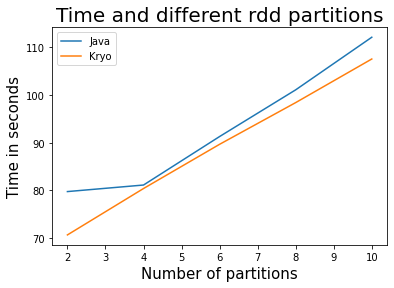

In [ ]:
plt.plot(list(partitioning_time_java.keys()), list(partitioning_time_java.values()),label="Java")
plt.plot(list(partitioning_time_kryo.keys()), list(partitioning_time_kryo.values()),label="Kryo")
plt.ylabel('Time in seconds',fontsize=15)
plt.xlabel('Number of partitions',fontsize=15)
plt.title('Time and different rdd partitions',fontsize=20)
plt.legend()
plt.show()

JAVA AND KRYO SERIALIZERS - DIFFERENT THRESHOLDS

In [ ]:
del threshold
del rdd0
del rdd
del spark
del sc

In [ ]:
#Apriori using Java serilizer
spark = SparkSession.builder.master("local[*]").getOrCreate() 
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.JavaSerializer")

rdd0 = sc.parallelize(ENdf,2)
rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x)))))) 

percentage = [0.05,0.075,0.1,0.125,0.15,0.175,0.2]
multiple = rdd.count()
threshold = [x * multiple for x in percentage]

support_time_java = dict()
for i in threshold:
  start = time.time()
  APriori(rdd,i)  
  end = time.time()
  support_time_java[i] = end - start
  print(support_time_java[i])

69.8317620754242
54.91229486465454
52.5312774181366
10.10934853553772
9.784132957458496
9.789589881896973
9.67954707145691


In [ ]:
del threshold
del rdd0
del rdd
del multiple
del percentage
del spark
del sc

In [ ]:
#Apriori using Kryo serilizer
spark = SparkSession.builder.master("local[*]").getOrCreate() 
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")


rdd0 = sc.parallelize(ENdf,2)
rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x)))))) 
percentage = [0.05,0.075,0.1,0.125,0.15,0.175,0.2]
multiple = rdd.count()
threshold = [x * multiple for x in percentage]

support_time_kryo = dict()
for i in threshold:
  start1 = time.time()

  APriori(rdd,i)  
  end1 = time.time()
  support_time_kryo[i] = end1 - start1
  print(support_time_kryo[i])

68.99427580833435
55.371705293655396
52.98316502571106
10.054839372634888
9.917023181915283
9.624844312667847
9.438341617584229


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

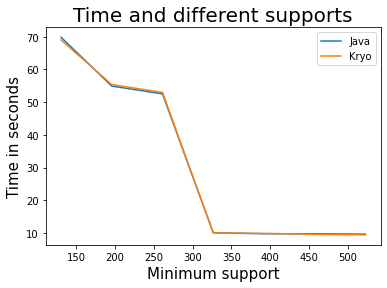

In [ ]:
plt.plot(list(support_time_java.keys()), list(support_time_java.values()),label="Java")
plt.plot(list(support_time_kryo.keys()), list(support_time_kryo.values()),label="Kryo")
plt.ylabel('Time in seconds',fontsize=15)
plt.xlabel('Minimum support',fontsize=15)
plt.title('Time and different supports',fontsize=20)
plt.legend()
plt.legend()
plt.show()

EXECUTION TIME AND INCREASING DATA SIZE - ONLY KRYO SERIALIZER IS USED

In [ ]:
del rdd0
del rdd
del spark
del sc
del threshold

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate() 
sc = spark.sparkContext
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")

sample = np.arange(0.1, 1.1, step=0.1)


sampling_time = dict()
for i in sample:
  
  only_english=df[df['language'].str.contains('en')]
  ENdf=only_english[{"text"}]
  ENdf=ENdf.sample(frac=i, replace=False, random_state=1)
  ENdf=ENdf.text.tolist()
  rdd0 = sc.parallelize(ENdf,2)
  rdd=rdd0.map(lambda x: (1,list(set(text_cleaning(deEmojify(x)))))) 
  threshold=rdd.count()*0.5

  start2 = time.time()
  APriori(rdd,threshold)  
  end2 = time.time()
  sampling_time[i] = end2 - start2
  print(sampling_time[i])


18.747223138809204
35.773361921310425
52.63619422912598
70.89056777954102
86.86430644989014
104.13337826728821
120.86569261550903
139.32417821884155
155.93398690223694
170.876606464386


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

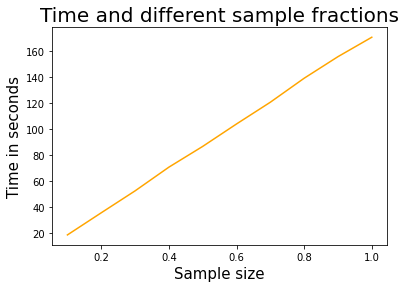

In [ ]:
plt.plot(list(sampling_time.keys()), list(sampling_time.values()),color='orange')

plt.ylabel('Time in seconds',fontsize=15)
plt.xlabel('Sample size',fontsize=15)
plt.title('Time and different sample fractions',fontsize=20) 
plt.show()

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2